In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

df_normal_quality = pd.read_csv('df_normal_quality.csv', index_col=0)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

In [8]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)

lasso = Lasso(alpha =  0.00030615490713200075)

lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.00030615490713200075),
                                                                func =np.log, inverse_func=np.exp))])


kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

scores.mean()

0.9508125912427354

In [258]:
predictions = lasso_pipe.predict(X)
predictions[15]
np.exp(bv) - predictions[15]

85821.08685577997

In [19]:
lasso_pipe.fit(X, y)

# Create a SHAP explainer for the Lasso model

explainer = shap.Explainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values = explainer(lasso_pipe.named_steps['Preprocess'].transform(X))

shap_values

.values =
array([[-0.14062961,  0.        ,  0.00389524, ..., -0.        ,
         0.        ,  0.        ],
       [-0.08982944, -0.        ,  0.01006153, ..., -0.        ,
         0.        ,  0.        ],
       [-0.10246368,  0.        ,  0.00464006, ..., -0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.16101285, -0.        , -0.00198617, ..., -0.        ,
         0.        ,  0.        ],
       [ 0.11889872, -0.        ,  0.00166303, ..., -0.        ,
         0.        ,  0.        ],
       [ 0.13706044, -0.        , -0.00138379, ..., -0.        ,
         0.        ,  0.        ]])

.base_values =
array([11.97202651, 11.97202651, 11.97202651, ..., 11.97202651,
       11.97202651, 11.97202651])

.data =
array([[-0.91734198, -0.4       , -0.33139011, ...,  0.        ,
         1.        ,  1.        ],
       [-0.60453809,  1.4       , -1.23273964, ...,  0.        ,
         1.        ,  1.        ],
       [-0.68233387, -0.4       , -0.44026416, ...,  0

In [24]:
X.OverallQual

0       36
1       25
2       25
3       16
4       64
        ..
2575    36
2576     9
2577    25
2578    49
2579    64
Name: OverallQual, Length: 2333, dtype: int64

In [54]:
# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df = pd.DataFrame(shap_values.values, columns=transformed_feature_names)
# this are the values of X after preprocessing 
X_transformed_df = pd.DataFrame(lasso_pipe.named_steps['Preprocess'].transform(X), columns=transformed_feature_names)

X_transformed_df.robust_scaler__OverallQual

0       0.000000
1      -0.458333
2      -0.458333
3      -0.833333
4       1.166667
          ...   
2328    0.000000
2329   -1.125000
2330   -0.458333
2331    0.541667
2332    1.166667
Name: robust_scaler__OverallQual, Length: 2333, dtype: float64

In [51]:
X_transformed_df

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__SaleType_COD,one-hot-encoder__SaleType_CWD,one-hot-encoder__SaleType_Con,one-hot-encoder__SaleType_ConLD,one-hot-encoder__SaleType_ConLI,one-hot-encoder__SaleType_ConLw,one-hot-encoder__SaleType_Oth,one-hot-encoder__SaleType_VWD,one-hot-encoder__SaleType_WD,one-hot-encoder__SaleCondition_Normal
0,-0.917342,-0.4,-0.331390,-0.355114,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,-0.604538,1.4,-1.232740,-1.273687,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.682334,-0.4,-0.440264,-0.815029,0.0,0.0,0.0,0.0,0.0,-0.458333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,-0.620746,0.4,0.440264,-0.290777,0.0,0.0,0.0,0.0,0.0,-0.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.393841,0.2,0.000000,-0.226941,0.0,0.0,0.0,0.0,0.0,1.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.761750,-0.4,0.004661,-0.112842,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2329,0.504052,-0.6,1.687008,1.100025,0.0,1.0,0.0,0.0,0.0,-1.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2330,0.940032,0.8,0.528317,-0.762252,0.0,0.0,-2.0,0.0,0.0,-0.458333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2331,0.680713,0.2,-0.005100,-0.119879,0.0,0.0,0.0,0.0,0.0,0.541667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [33]:
y

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2575    121000
2576    139600
2577    145000
2578    217500
2579    215000
Name: SalePrice, Length: 2333, dtype: int64

In [31]:
shap_values_df.robust_scaler__OverallQual

0       0.004220
1      -0.047939
2      -0.047939
3      -0.090615
4       0.136990
          ...   
2328    0.004220
2329   -0.123808
2330   -0.047939
2331    0.065863
2332    0.136990
Name: robust_scaler__OverallQual, Length: 2333, dtype: float64

In [50]:
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

['one-hot-encoder__MSZoning',
 'one-hot-encoder__Street',
 'one-hot-encoder__LotConfig',
 'one-hot-encoder__Neighborhood',
 'one-hot-encoder__Condition1',
 'one-hot-encoder__Condition2',
 'one-hot-encoder__BldgType',
 'one-hot-encoder__HouseStyle',
 'one-hot-encoder__RoofStyle',
 'one-hot-encoder__RoofMatl',
 'one-hot-encoder__Exterior1st',
 'one-hot-encoder__Exterior2nd',
 'one-hot-encoder__MasVnrType',
 'one-hot-encoder__Foundation',
 'one-hot-encoder__Heating',
 'one-hot-encoder__CentralAir',
 'one-hot-encoder__Electrical',
 'one-hot-encoder__GarageType',
 'one-hot-encoder__GarageYN',
 'one-hot-encoder__PoolYN',
 'one-hot-encoder__Fence',
 'one-hot-encoder__SaleType',
 'one-hot-encoder__SaleCondition']

In [59]:
for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df[prefix] = shap_values_df[columns].mean(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df.drop(columns=columns, inplace=True)
    
    # Update the transformed data DataFrame similarly
    #X_transformed_df[prefix] = X_transformed_df[columns].mean(axis=1)
    #X_transformed_df.drop(columns=columns, inplace=True)

In [104]:
X.OverallQual

0       36
1       25
2       25
3       16
4       64
        ..
2575    36
2576     9
2577    25
2578    49
2579    64
Name: OverallQual, Length: 2333, dtype: int64

In [55]:
shap_values_df

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__SaleType_COD,one-hot-encoder__SaleType_CWD,one-hot-encoder__SaleType_Con,one-hot-encoder__SaleType_ConLD,one-hot-encoder__SaleType_ConLI,one-hot-encoder__SaleType_ConLw,one-hot-encoder__SaleType_Oth,one-hot-encoder__SaleType_VWD,one-hot-encoder__SaleType_WD,one-hot-encoder__SaleCondition_Normal
0,-0.140630,0.0,0.003895,-0.014793,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.004220,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,-0.089829,-0.0,0.010062,-0.036492,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.047939,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,-0.102464,0.0,0.004640,-0.025658,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.047939,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,-0.092462,-0.0,-0.001384,-0.013273,-0.000105,-0.000445,-0.000038,0.0,-0.0,-0.090615,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.072310,-0.0,0.001628,-0.011766,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.136990,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-0.115361,0.0,0.001596,-0.009070,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.004220,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2329,0.090208,0.0,-0.009913,0.019581,-0.000105,0.000590,-0.000038,0.0,-0.0,-0.123808,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2330,0.161013,-0.0,-0.001986,-0.024411,-0.000105,-0.000445,0.000723,0.0,-0.0,-0.047939,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2331,0.118899,-0.0,0.001663,-0.009236,-0.000105,-0.000445,-0.000038,0.0,-0.0,0.065863,...,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


In [79]:
# these are the ones with a value of 0 for everything shap value
# seem to be the ones dropped by lasso 
shap_values_df.columns[shap_values_df.sum() == 0]

Index(['robust_scaler__MSSubClass', 'robust_scaler__Utilities',
       'robust_scaler__LandSlope', 'robust_scaler__ExterCond',
       'robust_scaler__BsmtUnfSF', 'robust_scaler__2ndFlrSF',
       'robust_scaler__FullBath', 'robust_scaler__HalfBath',
       'robust_scaler__GarageQual', 'robust_scaler__PoolQC',
       'one-hot-encoder__Street', 'one-hot-encoder__Condition2',
       'one-hot-encoder__RoofStyle', 'one-hot-encoder__RoofMatl',
       'one-hot-encoder__Electrical', 'one-hot-encoder__GarageYN',
       'one-hot-encoder__PoolYN', 'one-hot-encoder__SaleType',
       'one-hot-encoder__SaleCondition'],
      dtype='object')

In [82]:
bv = shap_values.base_values[0]

In [93]:
dollar_shap_values.columns

Index(['robust_scaler__GrLivArea', 'robust_scaler__MSSubClass',
       'robust_scaler__LotFrontage', 'robust_scaler__LotArea',
       'robust_scaler__Alley', 'robust_scaler__LotShape',
       'robust_scaler__LandContour', 'robust_scaler__Utilities',
       'robust_scaler__LandSlope', 'robust_scaler__OverallQual',
       'robust_scaler__OverallCond', 'robust_scaler__YearBuilt',
       'robust_scaler__YearRemodAdd', 'robust_scaler__MasVnrArea',
       'robust_scaler__ExterQual', 'robust_scaler__ExterCond',
       'robust_scaler__BsmtQual', 'robust_scaler__BsmtCond',
       'robust_scaler__BsmtExposure', 'robust_scaler__BsmtFinType1',
       'robust_scaler__BsmtFinSF1', 'robust_scaler__BsmtFinType2',
       'robust_scaler__BsmtFinSF2', 'robust_scaler__BsmtUnfSF',
       'robust_scaler__TotalBsmtSF', 'robust_scaler__HeatingQC',
       'robust_scaler__1stFlrSF', 'robust_scaler__2ndFlrSF',
       'robust_scaler__LowQualFinSF', 'robust_scaler__BsmtFullBath',
       'robust_scaler__BsmtHalfBat

In [107]:
dollar_shap_values = np.exp(bv + shap_values_df) - np.exp(bv)
dollar_shap_values

,robust_scaler__GrLivArea,robust_scaler__MSSubClass,robust_scaler__LotFrontage,robust_scaler__LotArea,robust_scaler__Alley,robust_scaler__LotShape,robust_scaler__LandContour,robust_scaler__Utilities,robust_scaler__LandSlope,robust_scaler__OverallQual,...,one-hot-encoder__Foundation,one-hot-encoder__Heating,one-hot-encoder__CentralAir,one-hot-encoder__Electrical,one-hot-encoder__GarageType,one-hot-encoder__GarageYN,one-hot-encoder__PoolYN,one-hot-encoder__Fence,one-hot-encoder__SaleType,one-hot-encoder__SaleCondition
0,-20762.626997,0.0,617.682150,-2324.029572,-16.608237,-70.381688,-6.018430,0.0,0.0,669.317501,...,-181.509950,0.0,212.630746,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
1,-13597.013750,0.0,1600.426294,-5671.341726,-16.608237,-70.381688,-6.018430,0.0,0.0,-7408.125151,...,-181.509950,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0
2,-15413.286679,0.0,736.066330,-4009.054195,-16.608237,-70.381688,-6.018430,0.0,0.0,-7408.125151,...,-332.724005,0.0,212.630746,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
3,-13977.298614,0.0,-218.853561,-2086.847305,-16.608237,-70.381688,-6.018430,0.0,0.0,-13710.644563,...,-332.724005,0.0,212.630746,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
4,11868.059184,0.0,257.887348,-1851.161494,-16.608237,-70.381688,-6.018430,0.0,0.0,23235.898138,...,298.569909,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-17243.880271,0.0,252.832757,-1429.009944,-16.608237,-70.381688,-6.018430,0.0,0.0,669.317501,...,-332.724005,0.0,-2798.026258,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
2329,14940.602698,0.0,-1561.127624,3129.483438,-16.608237,93.344924,-6.018430,0.0,0.0,-18429.993725,...,-181.509950,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0
2330,27648.916016,0.0,-314.029555,-3816.619262,-16.608237,-70.381688,114.393659,0.0,0.0,-7408.125151,...,-181.509950,0.0,-2798.026258,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
2331,19981.888801,0.0,263.418219,-1455.078659,-16.608237,-70.381688,-6.018430,0.0,0.0,10774.774743,...,298.569909,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0


In [108]:
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('robust_scaler__', '', regex=False)
dollar_shap_values.columns = dollar_shap_values.columns.str.replace('one-hot-encoder__', '', regex=False)

In [98]:
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]
X_new_order

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,Foundation,Heating,CentralAir,Electrical,GarageType,GarageYN,PoolYN,Fence,SaleType,SaleCondition
0,856,30,62.472926,7890,0.0,1,4,4,3,36,...,CBlock,GasA,Y,SBrkr,Detchd,yes,no,NO,WD,Normal
1,1049,120,42.000000,4235,0.0,1,4,4,3,25,...,CBlock,GasA,Y,SBrkr,Attchd,yes,no,NO,WD,Normal
2,1001,30,60.000000,6060,0.0,1,4,4,3,25,...,BrkTil,GasA,Y,SBrkr,Detchd,yes,no,NO,WD,Normal
3,1039,70,80.000000,8146,0.0,1,4,4,3,16,...,BrkTil,GasA,Y,SBrkr,Detchd,yes,no,NO,WD,Normal
4,1665,60,70.000000,8400,0.0,1,4,4,3,64,...,PConc,GasA,Y,SBrkr,Attchd,yes,no,NO,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,952,30,70.105866,8854,0.0,1,4,4,3,36,...,BrkTil,Grav,N,FuseF,Detchd,yes,no,NO,WD,Normal
2576,1733,20,108.318076,13680,0.0,2,4,4,3,9,...,Slab,GasA,Y,FuseA,Attchd,yes,no,NO,WD,Normal
2577,2002,90,82.000000,6270,0.0,1,2,4,3,25,...,CBlock,GasA,N,FuseA,2Types,yes,no,NO,WD,Normal
2578,1842,60,69.884162,8826,0.0,1,4,4,3,49,...,PConc,GasA,Y,SBrkr,Attchd,yes,no,NO,WD,Normal


In [116]:
y

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2575    121000
2576    139600
2577    145000
2578    217500
2579    215000
Name: SalePrice, Length: 2333, dtype: int64

In [127]:
lasso_pipe.predict(X)

array([125415.72820466, 130117.32966261, 115865.46638959, ...,
       153059.8841348 , 224552.16436075, 223787.78834833])

0       126000
1       139500
2       124900
3       114000
4       227000
         ...  
2575    121000
2576    139600
2577    145000
2578    217500
2579    215000
Name: SalePrice, Length: 2333, dtype: int64

In [137]:
np.exp(bv) + dollar_shap_values.iloc[0].sum()

123031.14322794709

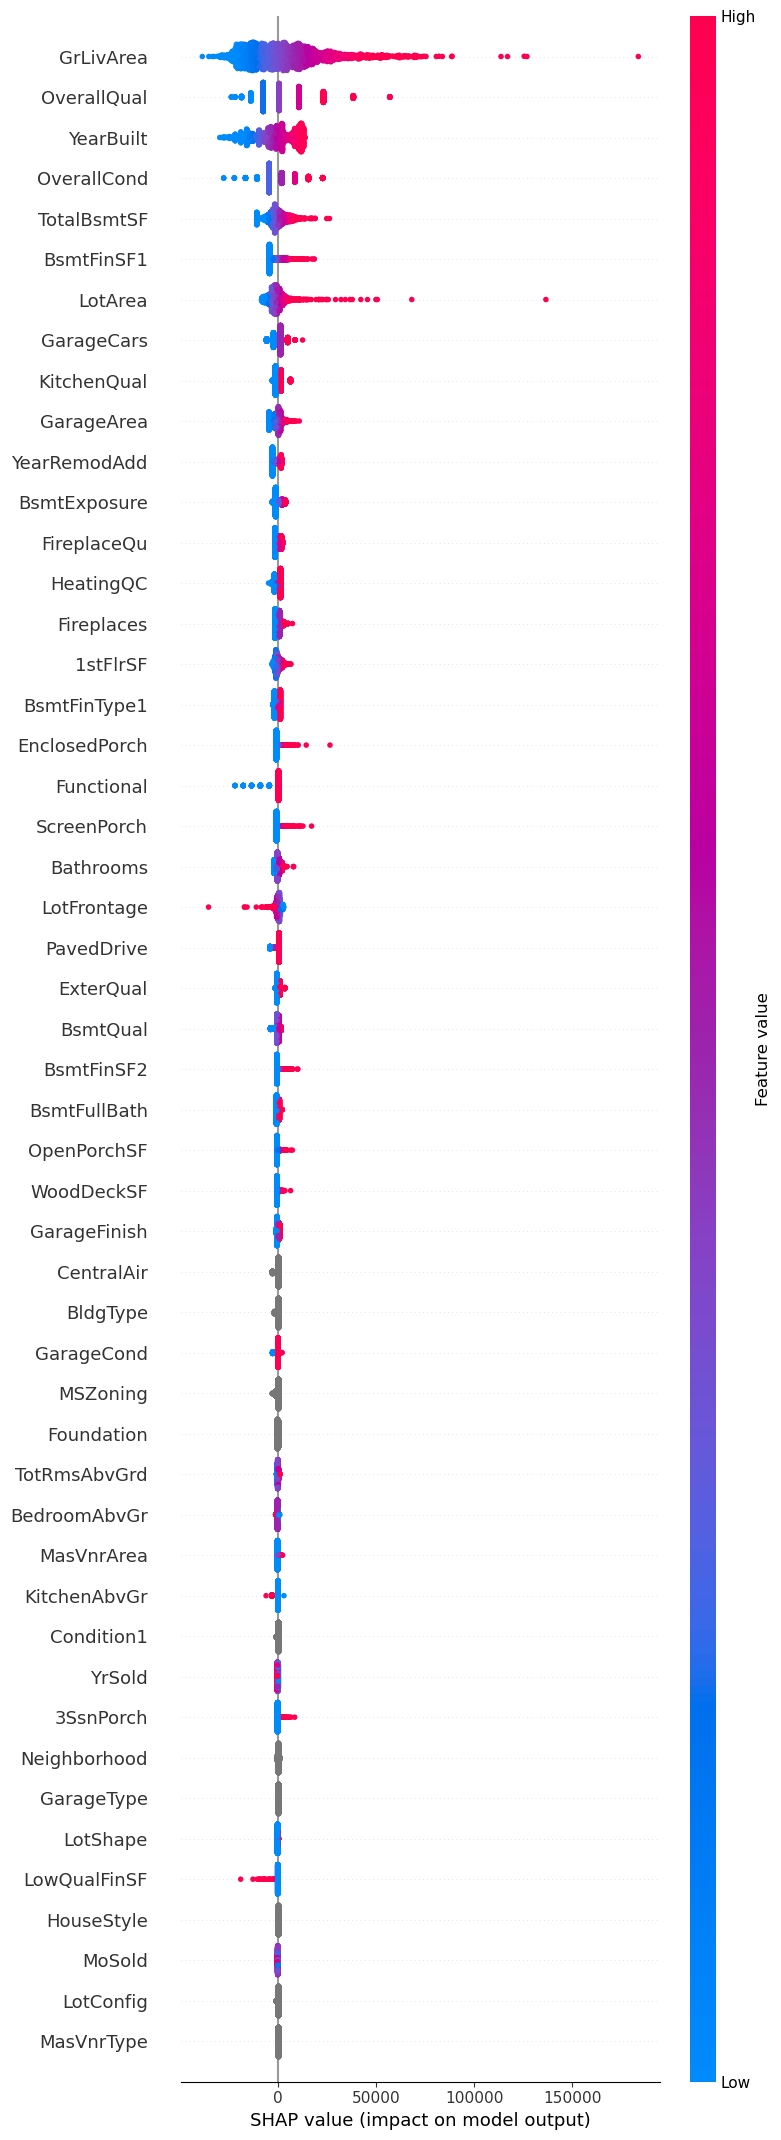

In [221]:
shap.summary_plot(dollar_shap_values.values,
                  X_new_order.values, 
                  feature_names=dollar_shap_values.columns,
                 max_display= 50)

In [135]:
np.exp(bv) + (dollar_shap_values.iloc[2332].sum())

215452.46944563725

In [48]:
# 25 quality of 5
#139500
#-0.458333
np.exp(11.97202651 + 0.136990) - np.exp(11.97202651)

23235.9509169574

In [ ]:
125415.72820466

In [37]:
np.exp( 0.136990)

1.1468166802962543

In [38]:
np.exp(11.97202651)

158265.06136816728

In [142]:
dollar_shap_values

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,Foundation,Heating,CentralAir,Electrical,GarageType,GarageYN,PoolYN,Fence,SaleType,SaleCondition
0,-20762.626997,0.0,617.682150,-2324.029572,-16.608237,-70.381688,-6.018430,0.0,0.0,669.317501,...,-181.509950,0.0,212.630746,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
1,-13597.013750,0.0,1600.426294,-5671.341726,-16.608237,-70.381688,-6.018430,0.0,0.0,-7408.125151,...,-181.509950,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0
2,-15413.286679,0.0,736.066330,-4009.054195,-16.608237,-70.381688,-6.018430,0.0,0.0,-7408.125151,...,-332.724005,0.0,212.630746,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
3,-13977.298614,0.0,-218.853561,-2086.847305,-16.608237,-70.381688,-6.018430,0.0,0.0,-13710.644563,...,-332.724005,0.0,212.630746,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
4,11868.059184,0.0,257.887348,-1851.161494,-16.608237,-70.381688,-6.018430,0.0,0.0,23235.898138,...,298.569909,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,-17243.880271,0.0,252.832757,-1429.009944,-16.608237,-70.381688,-6.018430,0.0,0.0,669.317501,...,-332.724005,0.0,-2798.026258,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
2329,14940.602698,0.0,-1561.127624,3129.483438,-16.608237,93.344924,-6.018430,0.0,0.0,-18429.993725,...,-181.509950,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0
2330,27648.916016,0.0,-314.029555,-3816.619262,-16.608237,-70.381688,114.393659,0.0,0.0,-7408.125151,...,-181.509950,0.0,-2798.026258,0.0,-124.547726,0.0,0.0,10.447082,0.0,0.0
2331,19981.888801,0.0,263.418219,-1455.078659,-16.608237,-70.381688,-6.018430,0.0,0.0,10774.774743,...,298.569909,0.0,212.630746,0.0,79.680274,0.0,0.0,10.447082,0.0,0.0


In [ ]:
shap.Ex

In [150]:
X.OverallQual

0       36
1       25
2       25
3       16
4       64
        ..
2575    36
2576     9
2577    25
2578    49
2579    64
Name: OverallQual, Length: 2333, dtype: int64

In [159]:
X_new_order.GrLivArea

0        856
1       1049
2       1001
3       1039
4       1665
        ... 
2575     952
2576    1733
2577    2002
2578    1842
2579    1911
Name: GrLivArea, Length: 2333, dtype: int64

In [251]:
y[15]

163000

In [252]:
X.iloc[15]

GrLivArea           864
MSSubClass           30
MSZoning             RL
LotFrontage        45.0
LotArea            8248
                  ...  
MoSold                9
YrSold             2008
SaleType            WD 
SaleCondition    Normal
Bathrooms           2.0
Name: 17, Length: 78, dtype: object

In [263]:
np.exp(bv) + (exp.values[15].sum())

48563.289444306225

In [260]:
exp.values[15].sum()

-109701.77237368276

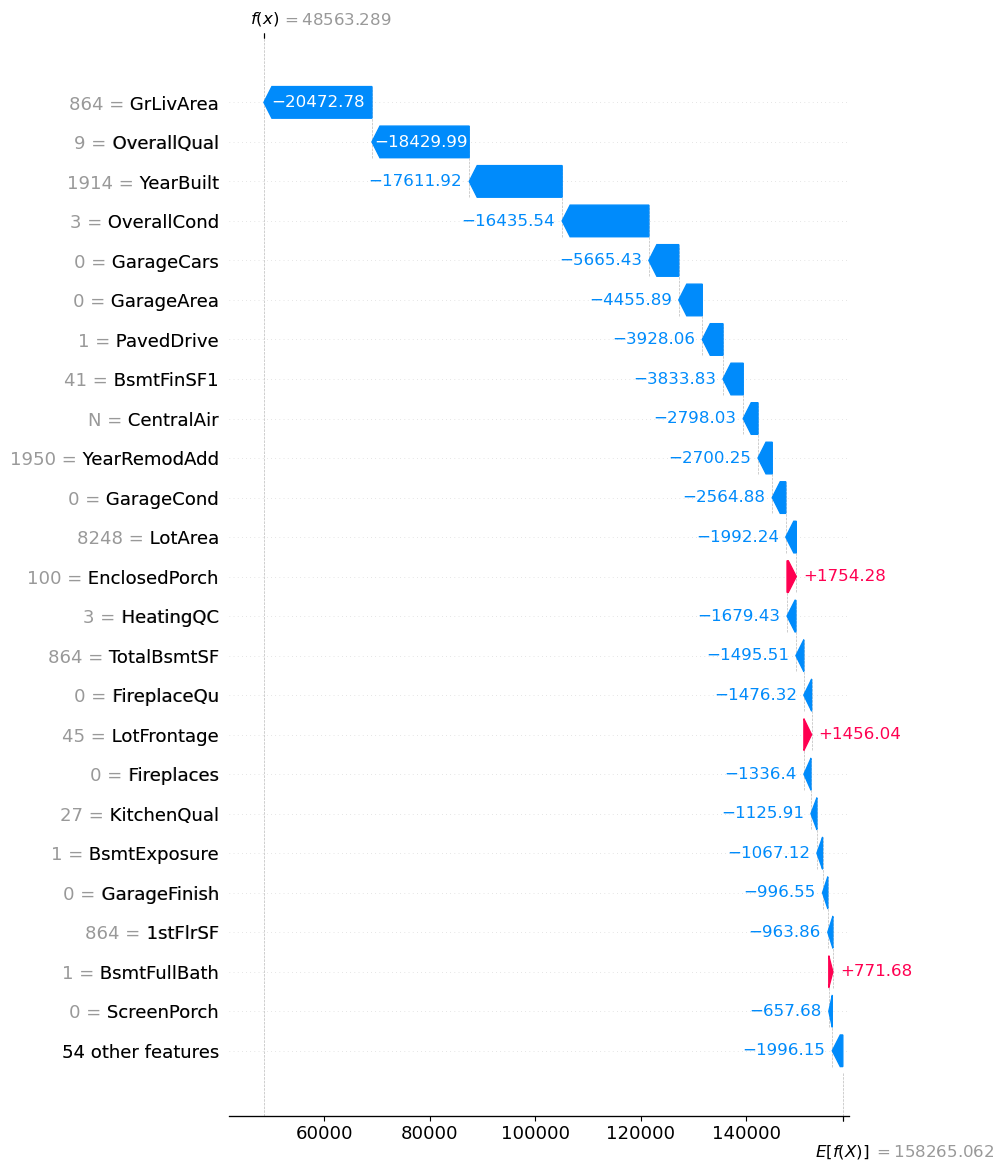

In [269]:
# the first is the values, second is the base values, third orinal values
# and last is just the names 
exp = shap.Explanation(dollar_shap_values.values, np.exp(shap_values.base_values),
                      X_new_order, feature_names=dollar_shap_values.columns)
shap.waterfall_plot(exp[15], max_display= 25)

In [183]:
categorical_columns_selector(X)

['MSZoning',
 'Street',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageType',
 'GarageYN',
 'PoolYN',
 'Fence',
 'SaleType',
 'SaleCondition']

In [ ]:
# taking the SHAP values and averaging them accross quality groups 
X.groupby('OverallQual')

In [ ]:
X.groupby('OverallQual').mean()

In [203]:
dollar_shap_values.loc[:, numerical_columns_selector(X)].groupby('OverallQual').mean()

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallCond,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,MoSold,YrSold,Bathrooms
OverallQual,,,,,,,,,,,,,,,,,,,,,
-23635.167448,-16148.999677,0.0,-439.389515,5185.834469,-16.608237,-15.806151,114.416560,0.0,0.0,-20136.645320,...,-2411.370965,-459.517357,-402.213443,376.235069,-72.058301,-657.678750,0.0,74.396199,84.346178,-1225.224246
-21706.329203,-25046.355281,0.0,288.785112,-401.867350,-16.608237,-70.381688,1.505895,0.0,0.0,-13307.279378,...,-3928.058848,-359.015673,-184.732544,88.554652,-72.058301,-657.678750,0.0,15.870169,-78.935780,-1554.067910
-18429.993725,-14124.358023,0.0,410.210133,-738.993925,56.125292,-49.915861,3.389123,0.0,0.0,-6454.638734,...,-1440.259197,-302.207995,-9.567913,441.169737,-72.058301,-342.671698,0.0,-24.606539,55.408935,-1009.279748
-13710.644563,-9580.238232,0.0,604.395238,-1994.549329,18.114413,-47.890838,4.567374,0.0,0.0,-735.775451,...,-541.147039,-213.232221,-112.432521,50.888307,-27.582115,-502.066705,0.0,-8.854645,7.728818,-854.618143
-7408.125151,-5955.981790,0.0,182.368943,-650.665188,8.593540,-25.128815,1.764776,0.0,0.0,1649.811717,...,131.277178,-116.236627,-38.348917,-13.402858,-35.346745,-237.334243,0.0,-13.403674,24.686297,-513.309743
669.317501,2233.707825,0.0,274.920948,-923.811203,10.539096,-5.146498,2.265739,0.0,0.0,950.601859,...,355.831603,-24.919203,131.956292,-87.625837,-28.115156,-116.592177,0.0,-9.393187,15.250763,80.206674
10774.774743,13698.124550,0.0,103.679886,-192.361059,21.286908,13.697610,3.206396,0.0,0.0,-1165.106201,...,480.561624,80.441016,397.906211,-359.958148,-9.577228,-173.308100,0.0,-9.786804,15.785618,819.438948
23235.898138,22257.791190,0.0,-21.509739,-29.568987,8.683824,31.792530,7.708961,0.0,0.0,-2706.187384,...,585.472092,201.266532,606.787584,-518.532818,-28.527143,-165.367419,0.0,-20.141063,9.181228,1044.438440
38472.568867,26391.301481,0.0,-401.468354,1757.601744,-16.608237,45.811391,26.027277,0.0,0.0,-4389.140576,...,622.004802,634.042949,695.401778,-756.967570,-72.058301,-523.657287,0.0,-9.580641,2.113875,1305.883471


In [195]:
X.loc[:, numerical_columns_selector(X)].groupby('OverallQual').mean()

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallCond,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,MoSold,YrSold,Bathrooms
OverallQual,,,,,,,,,,,,,,,,,,,,,
1,946.000000,23.333333,84.779413,15423.333333,0.000000,1.333333,2.000000,4.0000,2.000000,2.333333,...,1.666667,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,3.000000,2007.333333,1.333333
4,731.250000,36.250000,69.407737,9879.000000,0.000000,1.000000,3.875000,3.8750,3.000000,3.500000,...,1.000000,20.875000,16.125000,33.625000,0.000000,0.000000,0.000000,5.125000,2008.625000,1.125000
9,1018.406250,45.312500,66.951309,9439.312500,0.218750,1.125000,3.843750,4.0000,2.906250,4.625000,...,2.093750,32.562500,29.000000,47.468750,0.000000,10.531250,0.093750,6.593750,2007.562500,1.468750
16,1134.978022,63.571429,62.871702,8192.054945,0.104396,1.137363,3.824176,4.0000,2.945055,5.543956,...,2.489011,51.060440,21.401099,31.983516,2.637363,5.225275,0.016484,6.021978,2007.939560,1.565934
25,1228.985141,48.194651,71.704825,9624.276374,0.075780,1.276374,3.870728,4.0000,2.953938,5.916790,...,2.784547,71.132244,26.879643,29.423477,2.185736,14.008915,0.000000,6.187221,2007.805349,1.780832
36,1427.027200,65.640000,69.789118,9325.395200,0.081600,1.398400,3.862400,3.9984,2.963200,5.812800,...,2.883200,89.990400,39.499200,26.332800,2.614400,18.073600,0.014400,6.041600,2007.880000,2.152800
49,1684.610766,62.981366,73.564179,10011.277433,0.113872,1.513458,3.846791,4.0000,2.960663,5.488613,...,2.937888,111.896480,59.163561,15.689441,3.703934,16.136646,0.012422,6.055901,2007.875776,2.614907
64,1862.044000,60.620000,75.961042,10296.252000,0.076000,1.624000,3.772000,4.0000,2.924000,5.252000,...,2.984000,136.976000,74.620000,9.436000,2.592000,16.436000,0.020000,6.432000,2007.928000,2.756000
81,1954.370968,50.645161,83.924553,12136.645161,0.000000,1.709677,3.467742,4.0000,2.967742,5.000000,...,3.000000,226.370968,81.209677,0.000000,0.000000,4.500000,0.000000,6.048387,2007.983871,2.919355


In [200]:
numerical_columns_selector(X)

['GrLivArea',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolQC',
 'MoSold',
 'YrSold',
 'Bathrooms']

In [212]:
exp2 = shap.Explanation(dollar_shap_values.loc[:, numerical_columns_selector(X)].groupby('OverallQual').mean().values, 
                        shap_values.base_values,
                        X.loc[:, numerical_columns_selector(X)].groupby('OverallQual').mean())
exp2

.values =
array([[-1.61489997e+04,  0.00000000e+00, -4.39389515e+02,
         5.18583447e+03, -1.66082373e+01, -1.58061507e+01,
         1.14416560e+02,  0.00000000e+00,  0.00000000e+00,
        -2.01366453e+04, -9.72577936e+03, -2.67391566e+03,
        -1.26378696e+02, -9.87685881e+02,  0.00000000e+00,
        -2.96475451e+03,  5.79676229e+02, -4.99472877e+02,
        -1.44964997e+03, -3.11777039e+03,  5.50316730e+01,
        -4.25902616e+02,  0.00000000e+00, -8.26681381e+03,
        -1.67451702e+03, -6.19071043e+02,  0.00000000e+00,
         0.00000000e+00, -1.29216948e+02,  1.70968153e+01,
         0.00000000e+00,  0.00000000e+00,  3.32374335e+02,
         6.12149755e+01, -2.08041956e+03, -3.74804282e+02,
        -1.01768352e+04, -1.33640158e+03, -1.47631919e+03,
        -7.95480969e+02, -4.50057345e+03, -3.55934151e+03,
         0.00000000e+00, -1.63829726e+03, -2.41137096e+03,
        -4.59517357e+02, -4.02213443e+02,  3.76235069e+02,
        -7.20583014e+01, -6.57678750e+02,  0.0

In [228]:
X.loc[X.OverallQual == 9]

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolYN,PoolQC,Fence,MoSold,YrSold,SaleType,SaleCondition,Bathrooms
17,864,30,RL,45.000000,8248,Pave,1.0,1,4,4,...,0,0,no,0.0,NO,9,2008,WD,Normal,2.0
37,492,30,RM,52.000000,7830,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,6,2006,WD,Normal,2.0
215,1040,90,RL,60.000000,8544,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,6,2009,WD,Normal,2.0
227,670,50,RL,51.000000,3500,Pave,0.0,1,4,4,...,0,0,no,0.0,MnPrv,7,2007,WD,Normal,2.0
399,774,30,RH,70.000000,4270,Pave,0.0,1,3,4,...,0,0,no,0.0,NO,5,2007,WD,Normal,1.0
634,1605,50,RM,60.000000,5790,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,5,2010,WD,Normal,2.0
834,894,30,C (all),120.000000,18000,Grvl,0.0,1,1,4,...,0,0,no,0.0,NO,8,2008,ConLD,Normal,1.0
853,725,30,RL,60.000000,10800,Pave,1.0,1,4,4,...,0,0,no,0.0,NO,11,2009,WD,Normal,1.5
975,713,30,RL,60.000000,10410,Pave,1.0,1,4,4,...,0,0,no,0.0,NO,10,2006,WD,Normal,1.0
1070,1077,30,RM,60.000000,9786,Pave,0.0,1,4,4,...,0,0,no,0.0,NO,5,2006,WD,Normal,1.0


In [222]:
X.loc[:, numerical_columns_selector(X)].groupby('OverallQual').mean()

,GrLivArea,MSSubClass,LotFrontage,LotArea,Alley,LotShape,LandContour,Utilities,LandSlope,OverallCond,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,MoSold,YrSold,Bathrooms
OverallQual,,,,,,,,,,,,,,,,,,,,,
1,946.000000,23.333333,84.779413,15423.333333,0.000000,1.333333,2.000000,4.0000,2.000000,2.333333,...,1.666667,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,3.000000,2007.333333,1.333333
4,731.250000,36.250000,69.407737,9879.000000,0.000000,1.000000,3.875000,3.8750,3.000000,3.500000,...,1.000000,20.875000,16.125000,33.625000,0.000000,0.000000,0.000000,5.125000,2008.625000,1.125000
9,1018.406250,45.312500,66.951309,9439.312500,0.218750,1.125000,3.843750,4.0000,2.906250,4.625000,...,2.093750,32.562500,29.000000,47.468750,0.000000,10.531250,0.093750,6.593750,2007.562500,1.468750
16,1134.978022,63.571429,62.871702,8192.054945,0.104396,1.137363,3.824176,4.0000,2.945055,5.543956,...,2.489011,51.060440,21.401099,31.983516,2.637363,5.225275,0.016484,6.021978,2007.939560,1.565934
25,1228.985141,48.194651,71.704825,9624.276374,0.075780,1.276374,3.870728,4.0000,2.953938,5.916790,...,2.784547,71.132244,26.879643,29.423477,2.185736,14.008915,0.000000,6.187221,2007.805349,1.780832
36,1427.027200,65.640000,69.789118,9325.395200,0.081600,1.398400,3.862400,3.9984,2.963200,5.812800,...,2.883200,89.990400,39.499200,26.332800,2.614400,18.073600,0.014400,6.041600,2007.880000,2.152800
49,1684.610766,62.981366,73.564179,10011.277433,0.113872,1.513458,3.846791,4.0000,2.960663,5.488613,...,2.937888,111.896480,59.163561,15.689441,3.703934,16.136646,0.012422,6.055901,2007.875776,2.614907
64,1862.044000,60.620000,75.961042,10296.252000,0.076000,1.624000,3.772000,4.0000,2.924000,5.252000,...,2.984000,136.976000,74.620000,9.436000,2.592000,16.436000,0.020000,6.432000,2007.928000,2.756000
81,1954.370968,50.645161,83.924553,12136.645161,0.000000,1.709677,3.467742,4.0000,2.967742,5.000000,...,3.000000,226.370968,81.209677,0.000000,0.000000,4.500000,0.000000,6.048387,2007.983871,2.919355


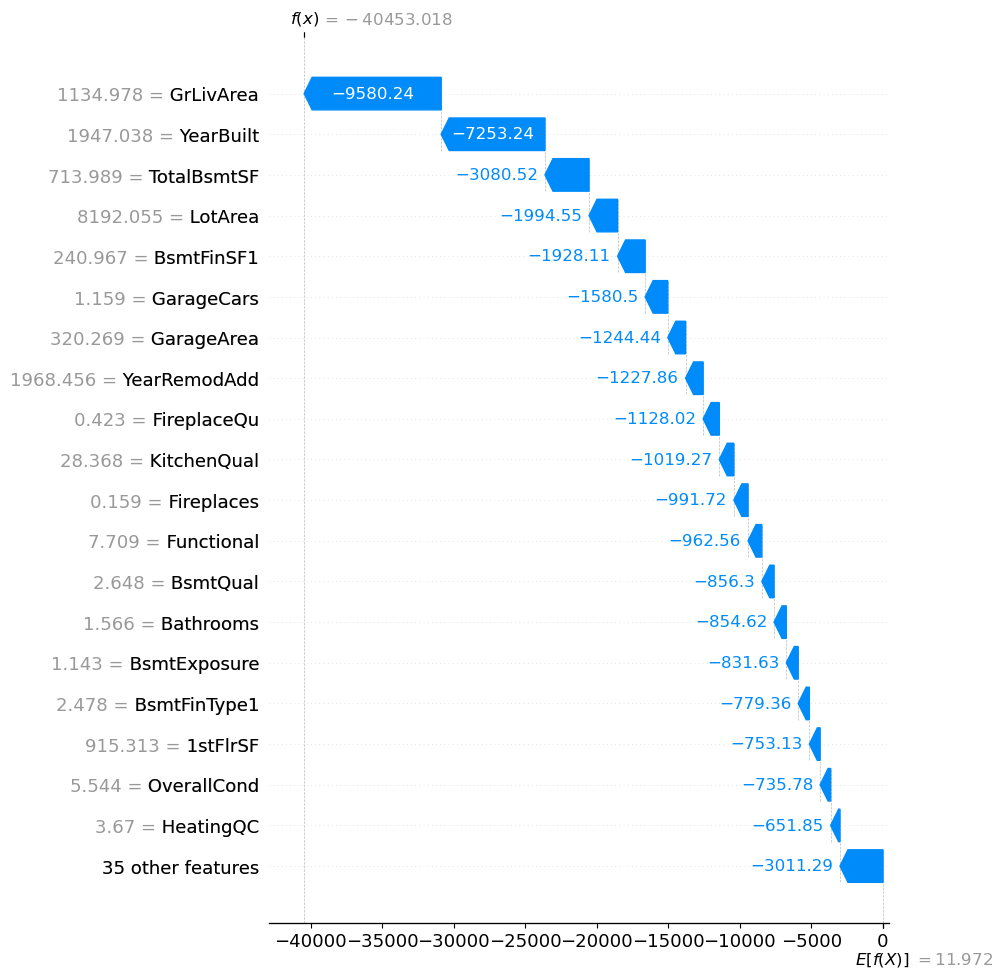

In [230]:
# waterfall plot for homes grouped by quality 
shap.waterfall_plot(exp2[3], max_display= 20)